# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиентный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return np.sin(2*w)
    

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    #ax = fig.gca(projection="3d")
    ax = plt.axes(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=15, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

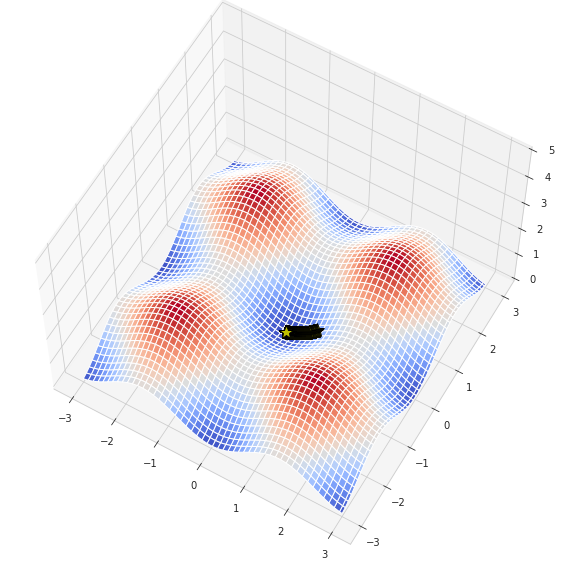

In [8]:
steps = gradient_desc_vis(f, grad_f, lr=0.01, num_iter=1000)

Посмотрим на зависимость значения функции от шага градиентного спуска.

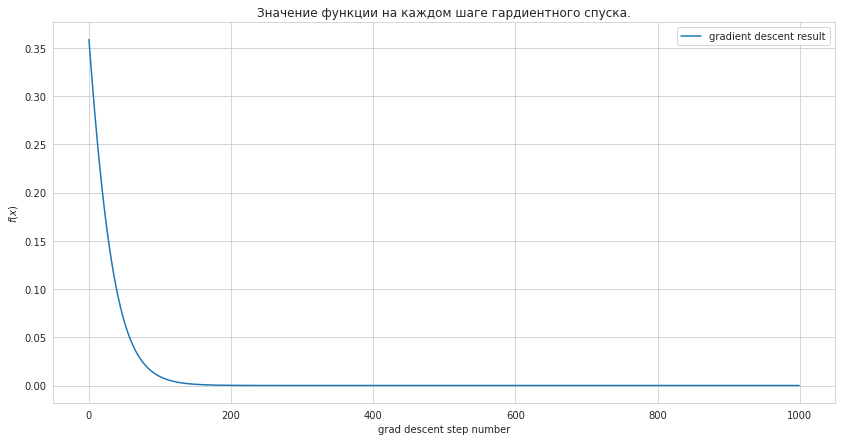

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    mse_score = ((y_true - y_pred)**2).sum() / y_pred.shape[0]
    return mse_score


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    grad_mse = (2 * np.matmul(X.T, (y_pred - y_true))) / y_pred.shape[0]    
    return grad_mse
    


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободный член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):

        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]

        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.matmul(X_test, self.W)
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

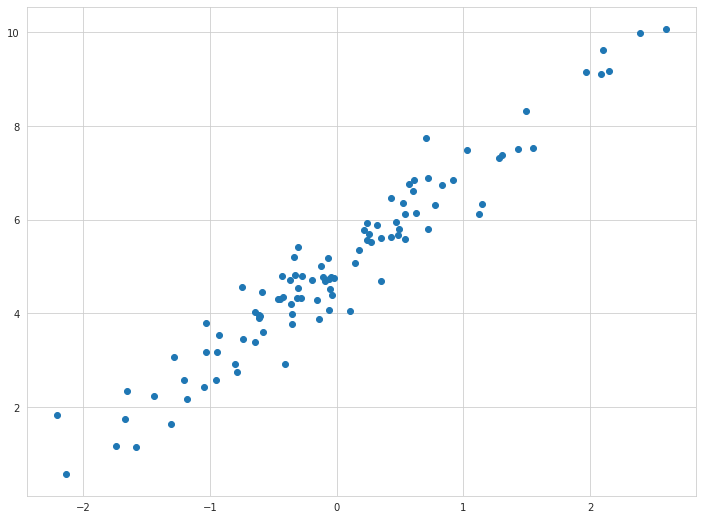

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

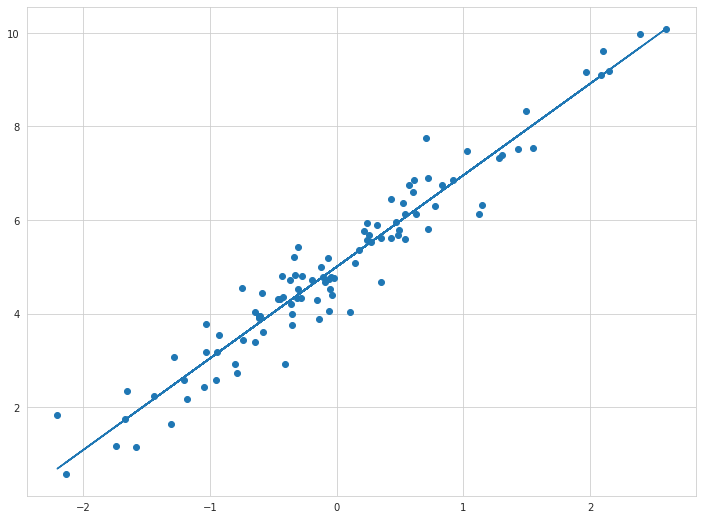

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alterna

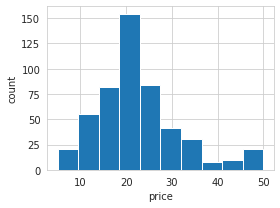

In [20]:
plt.figure(figsize=(4, 3))
plt.hist(y)
plt.xlabel('price')
plt.ylabel('count')
plt.tight_layout()

In [21]:
feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Ваш ход:

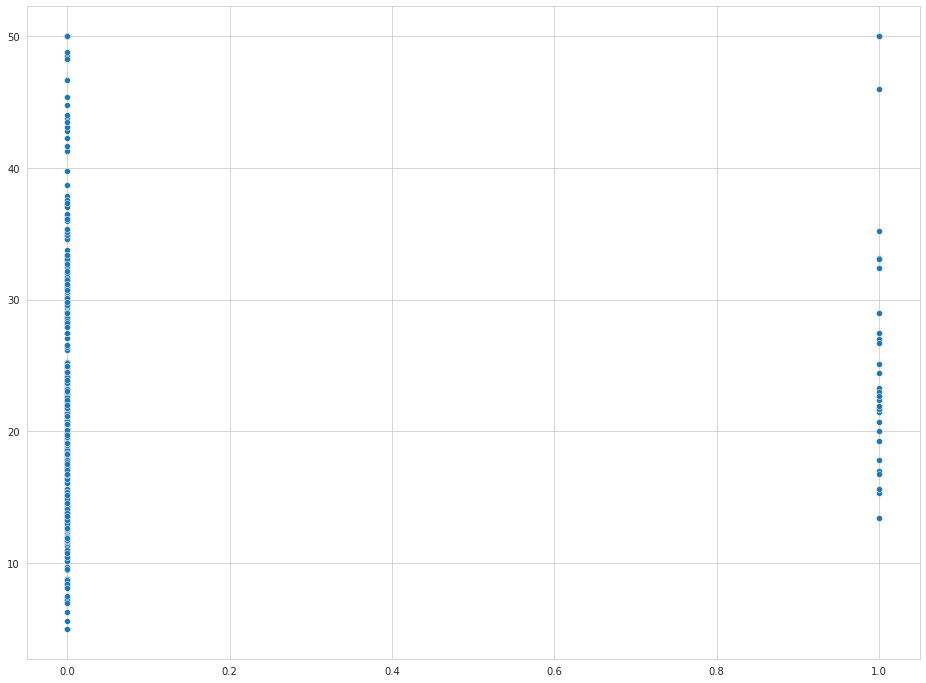

In [22]:
plt.figure(figsize = (16, 12))
sns.scatterplot(x=X[:,3], y=y);

<AxesSubplot:>

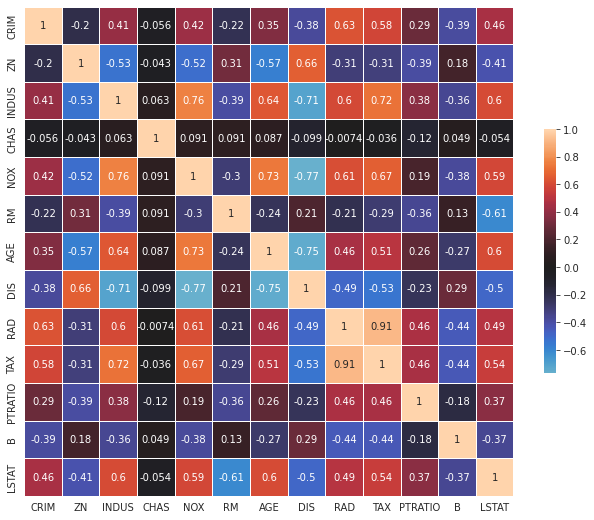

In [23]:
X_df = pd.DataFrame(X)
X_df.columns = feature_names

corr = X_df.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [24]:
X_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [25]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


##### Train-test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('Size of X_train: ', X_train.shape)
print('Size of X_test: ', X_test.shape)

print('Size of y_train: ', y_train.shape)
print('Size of y_test: ', y_test.shape)

Size of X_train:  (455, 13)
Size of X_test:  (51, 13)
Size of y_train:  (455,)
Size of y_test:  (51,)


##### Scaler

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
X_train_sdf = pd.DataFrame(X_train_scaled)
X_train_sdf.columns = feature_names

X_test_sdf = pd.DataFrame(X_test_scaled)
X_test_sdf.columns = feature_names

##### LinearRegression fit-predict

In [29]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))

Mean squared error: 46.590
Coefficient of determination: 0.5671


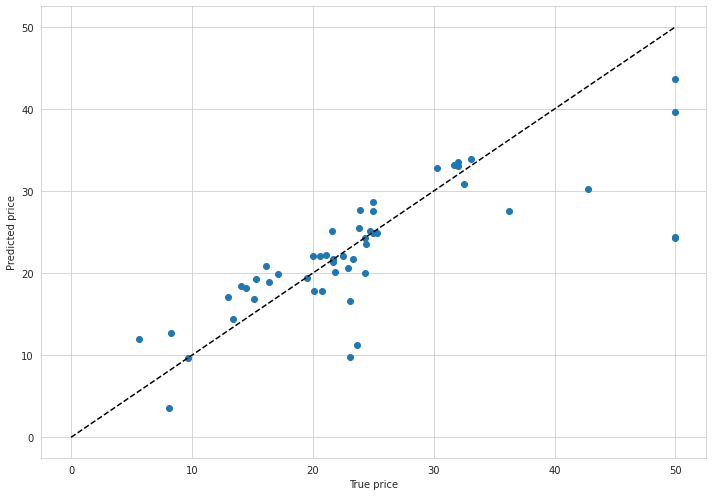

In [30]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

##### W/o scaling

In [31]:
model_wo_sc = LinearRegression().fit(X_train, y_train)
y_pred_wosc = model_wo_sc.predict(X_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred_wosc))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred_wosc))

Mean squared error: 46.590
Coefficient of determination: 0.5671


##### Normalizing

In [32]:
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('normalize', MinMaxScaler()), ('model_n', LinearRegression())])
pipe.fit(X_train, y_train)
# make predictions
y_prd_norm = pipe.predict(X_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_prd_norm))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_prd_norm))

Mean squared error: 46.590
Coefficient of determination: 0.5671


##### Multicollinearity

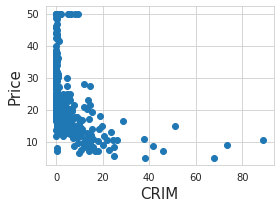

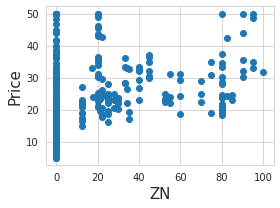

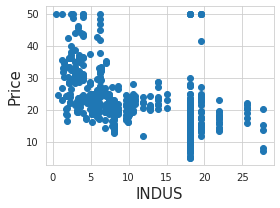

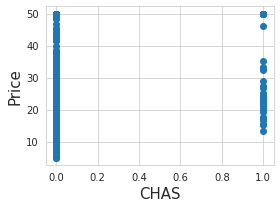

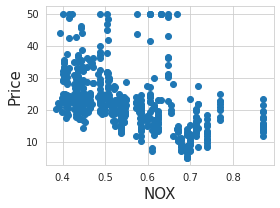

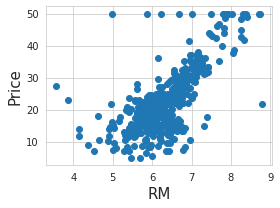

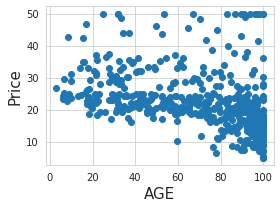

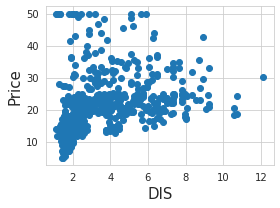

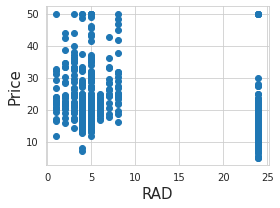

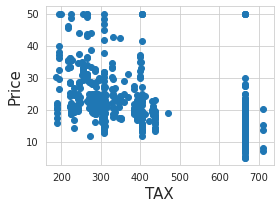

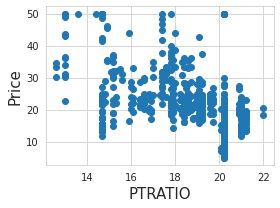

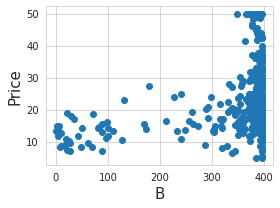

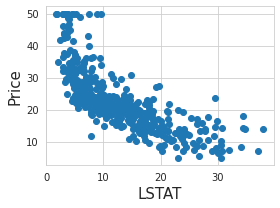

In [33]:
for index, feature_name in enumerate(feature_names):
    plt.figure(figsize=(4, 3))
    plt.scatter(X[:, index], y)
    plt.ylabel('Price', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
# Creating a dataframe of Variance inflation factors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_sdf.values, i) for i in range(X_train_sdf.shape[1])]

vif["features"] = X_train_sdf.columns
print(vif)

    VIF Factor features
0     1.765580     CRIM
1     2.284798       ZN
2     3.844764    INDUS
3     1.062725     CHAS
4     4.455057      NOX
5     2.027034       RM
6     3.290114      AGE
7     3.988387      DIS
8     7.433690      RAD
9     8.753638      TAX
10    1.753120  PTRATIO
11    1.369048        B
12    3.195690    LSTAT


VIF > 5 для TAX и RAD.

<AxesSubplot:>

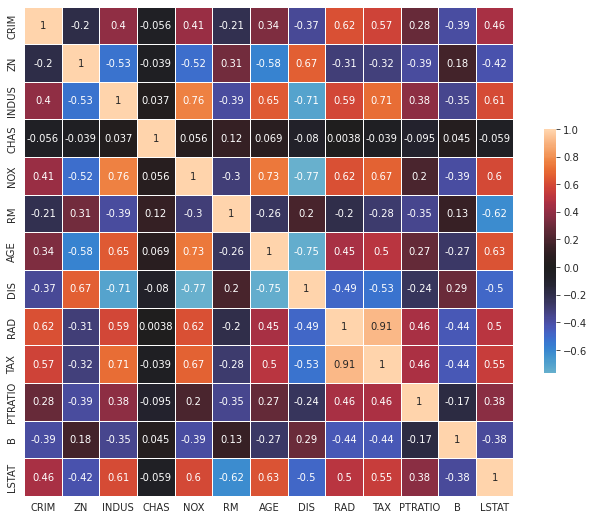

In [36]:
corr = X_train_sdf.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

##### Drop TAX

In [37]:
X_TAX_train, X_TAX_test = X_train_sdf.drop(['TAX'], axis=1), X_test_sdf.drop(['TAX'], axis=1)

print('Size of X_TAX_train: ', X_TAX_train.shape)
print('Size of y_test: ', y_train.shape)

print('Size of X_TAX_test: ', X_TAX_test.shape)
print('Size of y_test: ', y_test.shape)

Size of X_TAX_train:  (455, 12)
Size of y_test:  (455,)
Size of X_TAX_test:  (51, 12)
Size of y_test:  (51,)


In [38]:
vif_2 = pd.DataFrame()
vif_2["VIF Factor"] = [variance_inflation_factor(X_TAX_train.values, i) for i in range(X_TAX_train.shape[1])]

vif_2["features"] = X_TAX_train.columns
print(vif_2)

    VIF Factor features
0     1.765503     CRIM
1     2.193475       ZN
2     3.186171    INDUS
3     1.045937     CHAS
4     4.425328      NOX
5     2.012843       RM
6     3.289372      AGE
7     3.988118      DIS
8     2.803226      RAD
9     1.740094  PTRATIO
10    1.368165        B
11    3.190805    LSTAT


In [39]:
model_eTAX = LinearRegression().fit(X_TAX_train, y_train)
y_eTAX_pred = model_eTAX.predict(X_TAX_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_eTAX_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_eTAX_pred))

# Before:
# Mean squared error: 46.590
# Coefficient of determination: 0.5671

Mean squared error: 46.138
Coefficient of determination: 0.5713


Кааааапельку лучше.

##### Drop RAD

In [40]:
X_RAD_train, X_RAD_test = X_train_sdf.drop(['RAD'], axis=1), X_test_sdf.drop(['RAD'], axis=1)

print('Size of X_RAD_train: ', X_RAD_train.shape)
print('Size of y_test: ', y_train.shape)

print('Size of X_RAD_test: ', X_RAD_test.shape)
print('Size of y_test: ', y_test.shape)

Size of X_RAD_train:  (455, 12)
Size of y_test:  (455,)
Size of X_RAD_test:  (51, 12)
Size of y_test:  (51,)


In [41]:
vif_2 = pd.DataFrame()
vif_2["VIF Factor"] = [variance_inflation_factor(X_RAD_train.values, i) for i in range(X_RAD_train.shape[1])]

vif_2["features"] = X_RAD_train.columns
print(vif_2)

    VIF Factor features
0     1.648686     CRIM
1     2.264232       ZN
2     3.571283    INDUS
3     1.045626     CHAS
4     4.362321      NOX
5     1.962958       RM
6     3.273210      AGE
7     3.988366      DIS
8     3.300976      TAX
9     1.698379  PTRATIO
10    1.363912        B
11    3.175858    LSTAT


> все меньше 5.

In [42]:
model_eRAD = LinearRegression().fit(X_RAD_train, y_train)
y_eRAD_pred = model_eRAD.predict(X_RAD_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_eRAD_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_eRAD_pred))

# Before:
# Mean squared error: 46.138
# Coefficient of determination: 0.5713

Mean squared error: 48.451
Coefficient of determination: 0.5498


> Лучше не стало.

>> Модель без TAX среди использованных лучшая, R^2 = 0.5713, а MSE = 46.138.

##### Best Model

In [43]:
import statsmodels.api as sm

best_model = sm.OLS(y_train, sm.add_constant(X_TAX_train)).fit()
y_best_pred = best_model.predict(sm.add_constant(X_TAX_test))

print("Mean squared error: %.3f" % mean_squared_error(y_test, y_best_pred))
print("Coefficient of determination: %.4f" % r2_score(y_test, y_best_pred))
print('------------------')
print(best_model.summary())

Mean squared error: 46.138
Coefficient of determination: 0.5713
------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     114.2
Date:                Fri, 18 Feb 2022   Prob (F-statistic):          4.23e-127
Time:                        17:58:20   Log-Likelihood:                -1325.7
No. Observations:                 455   AIC:                             2677.
Df Residuals:                     442   BIC:                             2731.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

*R-squared:                       0.756*
*Adj. R-squared:                  0.750*

Все использованные переменные ('TAX' не был использован) кроме "AGE" и "INDUS" оказывают значимое влияние на цену доме (при уровне значимости 0.05).

#### Удалим из модели и TAX и AGE

In [44]:
X_AGE_train, X_AGE_test = X_train_sdf.drop(['TAX', 'AGE'], axis=1), X_test_sdf.drop(['TAX', 'AGE'], axis=1)

print('Size of X_AGE_train: ', X_AGE_train.shape)
print('Size of y_AGE_train: ', y_train.shape)

print('Size of X_AGE_test: ', X_AGE_test.shape)
print('Size of y_AGE_train: ', y_test.shape)

Size of X_AGE_train:  (455, 11)
Size of y_AGE_train:  (455,)
Size of X_AGE_test:  (51, 11)
Size of y_AGE_train:  (51,)


In [45]:
model_eAGE = LinearRegression().fit(X_AGE_train, y_train)
y_eAGE_pred = model_eAGE.predict(X_AGE_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_eAGE_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_eAGE_pred))

# Before:
# Mean squared error: 46.138
# Coefficient of determination: 0.5713

Mean squared error: 46.088
Coefficient of determination: 0.5717


Модель стала с использованием LinearRegression совсем немного лучше.

In [46]:
best_AGE_model = sm.OLS(y_train, sm.add_constant(X_AGE_train)).fit()
y_best_AGE_pred = best_AGE_model.predict(sm.add_constant(X_AGE_test))

print("Mean squared error: %.3f" % mean_squared_error(y_test, y_best_AGE_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_best_AGE_pred))
print('--------------------')
print(best_AGE_model.summary())

Mean squared error: 46.088
Coefficient of determination: 0.5717
--------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     124.9
Date:                Fri, 18 Feb 2022   Prob (F-statistic):          3.79e-128
Time:                        17:58:20   Log-Likelihood:                -1325.8
No. Observations:                 455   AIC:                             2676.
Df Residuals:                     443   BIC:                             2725.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

Уберем также и INDUS:

In [47]:
X_INDUS_train, X_INDUS_test = X_train_sdf.drop(['TAX', 'AGE', 'INDUS'], 
                                               axis=1), X_test_sdf.drop(['TAX', 'AGE', 'INDUS'], axis=1)


print('Size of X_INDUS_train: ', X_INDUS_train.shape)
print('Size of y_INDUS_train: ', y_train.shape)

print('Size of X_INDUS_test: ', X_INDUS_test.shape)
print('Size of y_INDUS_train: ', y_test.shape)

Size of X_INDUS_train:  (455, 10)
Size of y_INDUS_train:  (455,)
Size of X_INDUS_test:  (51, 10)
Size of y_INDUS_train:  (51,)


In [48]:
model_eINDUS = LinearRegression().fit(X_INDUS_train, y_train)
y_eINDUS_pred = model_eINDUS.predict(X_INDUS_test)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_eINDUS_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_eINDUS_pred))

# Before:
# Mean squared error: 46.088
# Coefficient of determination: 0.5717

Mean squared error: 46.083
Coefficient of determination: 0.5718


In [49]:
best_INDUS_model = sm.OLS(y_train, sm.add_constant(X_INDUS_train)).fit()
y_best_INDUS_pred = best_INDUS_model.predict(sm.add_constant(X_INDUS_test))

print("Mean squared error: %.3f" % mean_squared_error(y_test, y_best_INDUS_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_best_INDUS_pred))
print('--------------------')
print(best_INDUS_model.summary())

Mean squared error: 46.083
Coefficient of determination: 0.5718
--------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     137.0
Date:                Fri, 18 Feb 2022   Prob (F-statistic):          7.09e-129
Time:                        17:58:20   Log-Likelihood:                -1326.6
No. Observations:                 455   AIC:                             2675.
Df Residuals:                     444   BIC:                             2720.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

По сравнению с моделью, в которой мы используем все достуные данные (Mean squared error: 46.590, Coefficient of determination: 0.5671), модель, в которой мы используем только значимо влияющие признаки и не используем коррелирующие (т.е., не используем AGE, INDUS и TAX) -- лучше (Mean squared error: 46.083, Coefficient of determination: 0.5718), но не очень сильно.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задачах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справиться с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [50]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    return 1 / (1 + np.exp(-1 * output))   

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [51]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce_value = (-1 * np.sum(y_true * log(sigmoid(y_pred)) + (1 - y_true) * log(1 - sigmoid(y_pred)))) / n

    return bce_value


def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.matmul(X.T, (np.array(y_pred) - y_true))


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [52]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]

        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        return sigmoid(np.matmul(X_test, self.W))
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [53]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

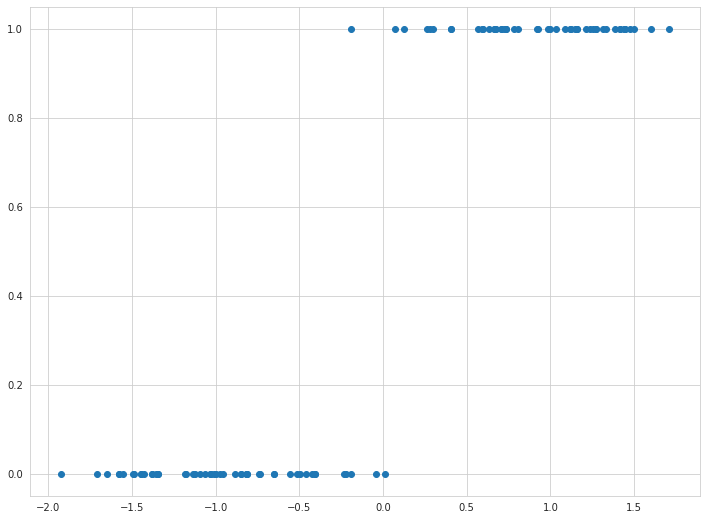

In [54]:
plt.scatter(X, y);

In [55]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

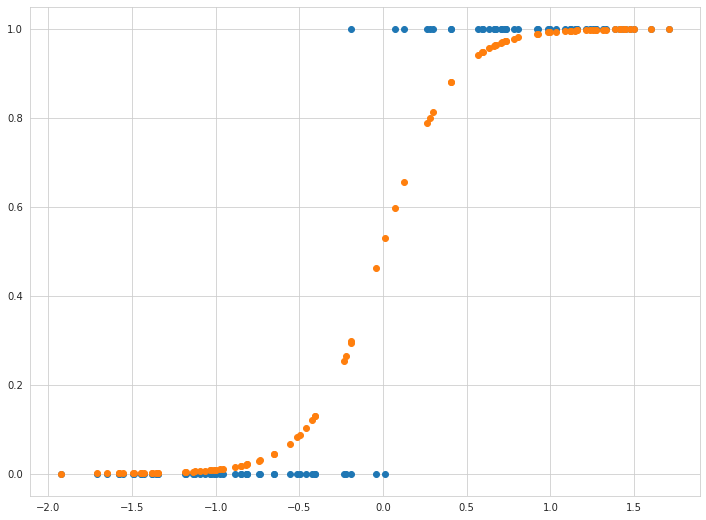

In [56]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [57]:
y_pred = np.where(y_pred > 0.5, 1, 0)

Если вероятность больше 0.5, относим к классу "1", иначе к 0.

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(f'precision_score: {precision_score(y, y_pred)}')
print(f'recall_score: {recall_score(y, y_pred)}')
print(f'f1_score: {f1_score(y, y_pred)}')
print(f'accuracy_score: {accuracy_score(y, y_pred)}')

precision_score: 0.98
recall_score: 0.98
f1_score: 0.98
accuracy_score: 0.98


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [59]:
pokemon = pd.read_csv("../data_folder/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [60]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [61]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


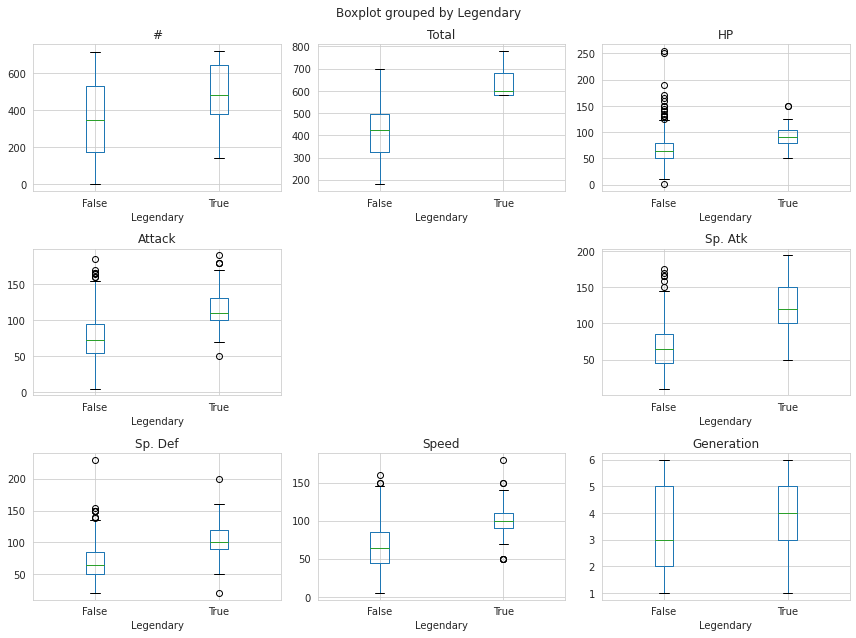

In [62]:
pokemon_bp = pokemon.drop(['Type 2', 'Name', 'Type 1'], axis=1)

fig, axes = plt.subplots(3, 3)

for i, el in enumerate(list(pokemon_bp.columns.values)[:-1]):
    pokemon_bp.boxplot(el, by="Legendary", ax=axes.flatten()[i])
    
fig.delaxes(axes[1,1])
plt.tight_layout() 

plt.show()

<AxesSubplot:>

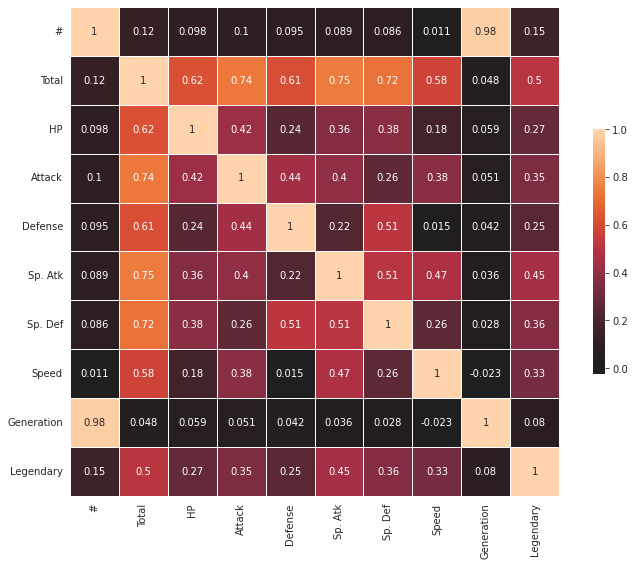

In [63]:
corr = pokemon.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

<AxesSubplot:>

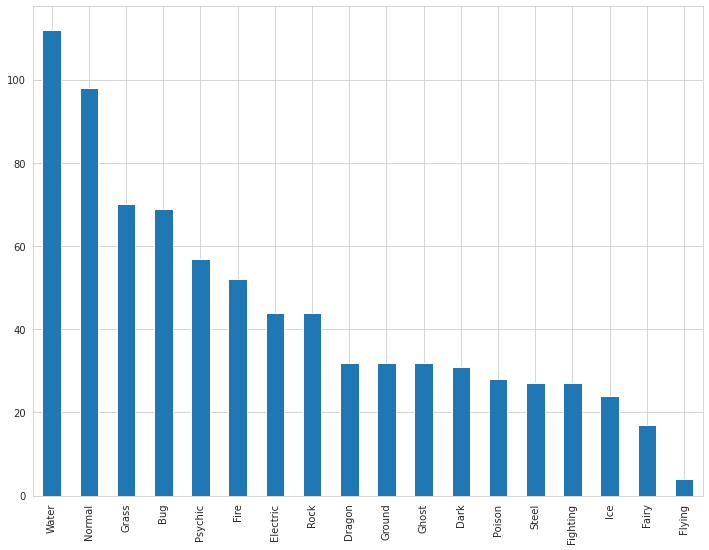

In [64]:
pokemon['Type 1'].value_counts().plot(kind='bar')

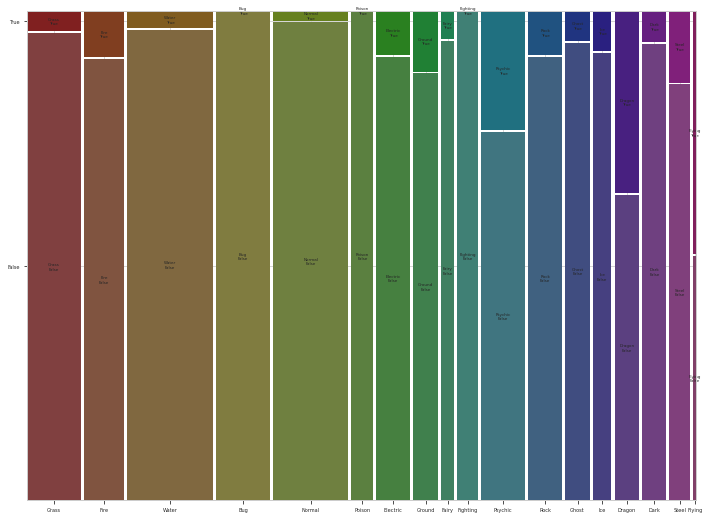

In [65]:
from statsmodels.graphics.mosaicplot import mosaic

plt.rcParams['font.size'] = 5.0
mosaic(pokemon, ['Type 1', 'Legendary'])
plt.show()
plt.close()

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

Не будем использовать для модели "#" - коррелирует с 'Generation'. Также для половины датасета не известен "Type 2", его тоже не будет использовать. Не будем использовать 'Name', т.к. связан  с "#".

#### С использованием 'Type 1'

In [66]:
new_pokemon = pokemon.drop(['Type 2', 'Name', '#'], axis=1)
new_pokemon['Type 1'] = new_pokemon['Type 1'].astype('category')

new_pokemon['Legendary']  = new_pokemon['Legendary']. astype(int)
new_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Type 1      800 non-null    category
 1   Total       800 non-null    int64   
 2   HP          800 non-null    int64   
 3   Attack      800 non-null    int64   
 4   Defense     800 non-null    int64   
 5   Sp. Atk     800 non-null    int64   
 6   Sp. Def     800 non-null    int64   
 7   Speed       800 non-null    int64   
 8   Generation  800 non-null    int64   
 9   Legendary   800 non-null    int64   
dtypes: category(1), int64(9)
memory usage: 57.8 KB


In [67]:
X = new_pokemon.drop('Legendary', axis=1)
y = new_pokemon['Legendary']

Разделите ваши данные на тестовую и тренировочную выборку.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('Size of X_train: ', X_train.shape)
print('Size of y_train: ', y_train.shape)

print('Size of X_test: ', X_test.shape)
print('Size of y_test: ', y_test.shape)

Size of X_train:  (720, 9)
Size of y_train:  (720,)
Size of X_test:  (80, 9)
Size of y_test:  (80,)


In [69]:
XT_train = pd.get_dummies(X_train, columns=['Type 1'], drop_first=True)
XT_test = pd.get_dummies(X_test, columns=['Type 1'], drop_first=True)

In [70]:
XT_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 550 to 5
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Total            720 non-null    int64
 1   HP               720 non-null    int64
 2   Attack           720 non-null    int64
 3   Defense          720 non-null    int64
 4   Sp. Atk          720 non-null    int64
 5   Sp. Def          720 non-null    int64
 6   Speed            720 non-null    int64
 7   Generation       720 non-null    int64
 8   Type 1_Dark      720 non-null    uint8
 9   Type 1_Dragon    720 non-null    uint8
 10  Type 1_Electric  720 non-null    uint8
 11  Type 1_Fairy     720 non-null    uint8
 12  Type 1_Fighting  720 non-null    uint8
 13  Type 1_Fire      720 non-null    uint8
 14  Type 1_Flying    720 non-null    uint8
 15  Type 1_Ghost     720 non-null    uint8
 16  Type 1_Grass     720 non-null    uint8
 17  Type 1_Ground    720 non-null    uint8
 18  Type 1_Ice

In [71]:
XT_train.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1_Dark,Type 1_Dragon,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,433.583333,69.379167,78.906944,74.059722,72.115278,71.255556,67.866667,3.359722,0.040278,0.041667,...,0.040278,0.087500,0.037500,0.029167,0.120833,0.037500,0.066667,0.054167,0.036111,0.145833
std,120.163802,25.065130,32.421056,31.171704,32.051407,26.964381,28.985421,1.676074,0.196747,0.199965,...,0.196747,0.282763,0.190116,0.168390,0.326160,0.190116,0.249617,0.226504,0.186696,0.353184
min,180.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,330.000000,50.000000,55.000000,50.000000,47.750000,50.000000,45.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,447.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,510.000000,80.000000,100.000000,90.000000,95.000000,89.000000,90.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,780.000000,250.000000,190.000000,230.000000,194.000000,200.000000,180.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
scaler = StandardScaler()
XT_train = scaler.fit_transform(XT_train)
XT_test = scaler.fit_transform(XT_test)

Обучите модель `LogisticRegression` из `sklearn`.

In [73]:
log_Tmodel = LogisticRegression()
log_Tmodel.fit(XT_train, y_train)
yT_pred = log_Tmodel.predict(XT_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [74]:
train_acc = log_Tmodel.score(XT_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

The Accuracy for Training Set is 96.94444444444444


In [75]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, yT_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

The Accuracy for Test Set is 91.25


In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

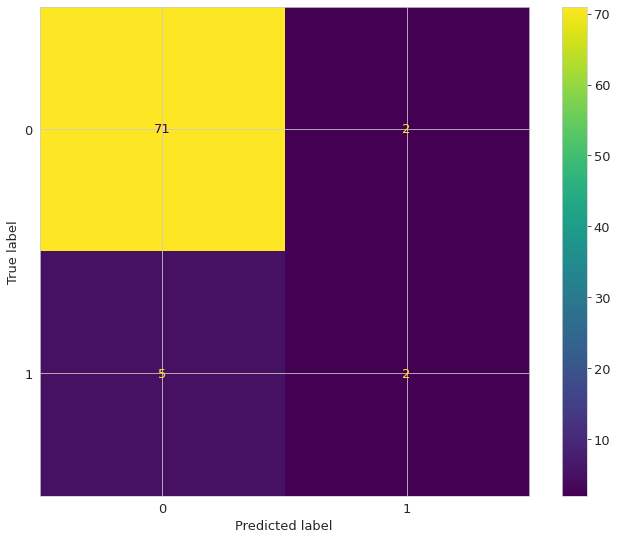

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['font.size'] = 13.0
cm = confusion_matrix(y_test, yT_pred, labels=log_Tmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_Tmodel.classes_)
disp.plot()
plt.rcParams['font.size'] = 16.0
plt.show()
plt.close()

In [78]:
from sklearn.metrics import roc_auc_score

yT_score = log_Tmodel.decision_function(XT_test)
aucT = roc_auc_score(y_test, yT_score)
print('AUC (площадь под ROC кривой): %.2f' % aucT)

AUC (площадь под ROC кривой): 0.92


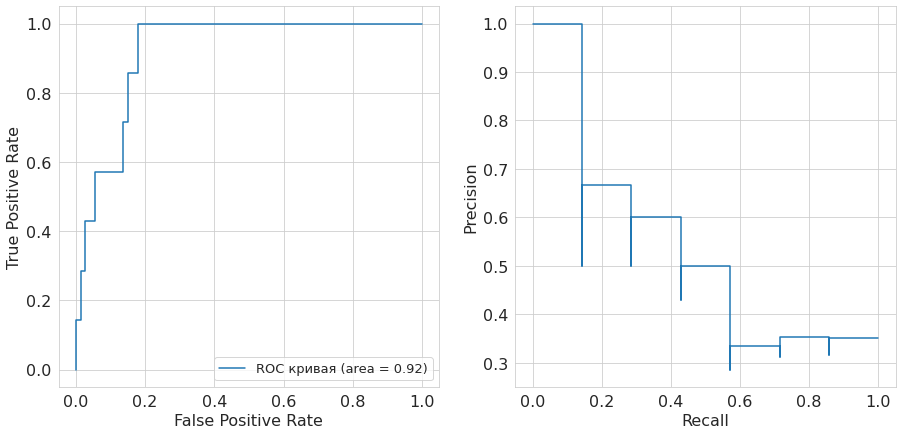

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams['font.size'] = 13.0


fpr, tpr, _ = roc_curve(y_test, yT_score, pos_label=log_Tmodel.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)


prec, recall, _ = precision_recall_curve(y_test, yT_score, pos_label=log_Tmodel.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)


roc_display.plot(ax=ax1, label='ROC кривая (area = %0.2f)' %aucT)
pr_display.plot(ax=ax2)
plt.show()

##### Без использования 'Type 1'

In [80]:
X_train = X_train.drop(['Type 1'], axis=1)
X_test = X_test.drop(['Type 1'], axis=1)

In [81]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [82]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [83]:
train_acc = log_model.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

The Accuracy for Training Set is 95.55555555555556


In [84]:
test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

The Accuracy for Test Set is 90.0


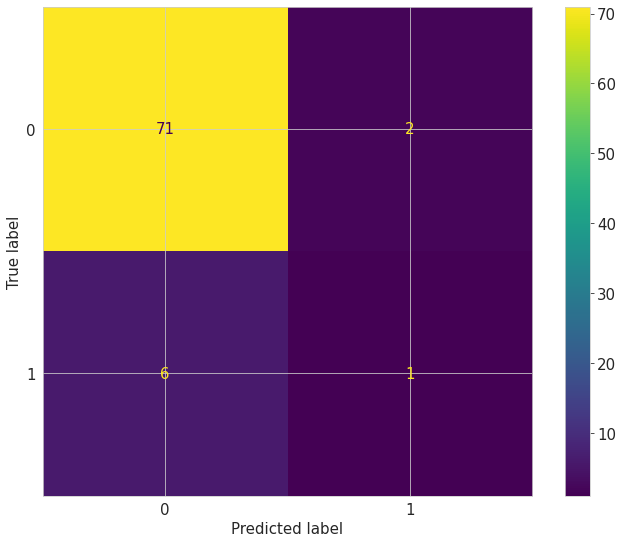

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

In [86]:
y_score = log_model.decision_function(X_test)
auc = roc_auc_score(y_test, y_score)
print('AUC (площадь под ROC кривой): %.2f' % auc)

AUC (площадь под ROC кривой): 0.90


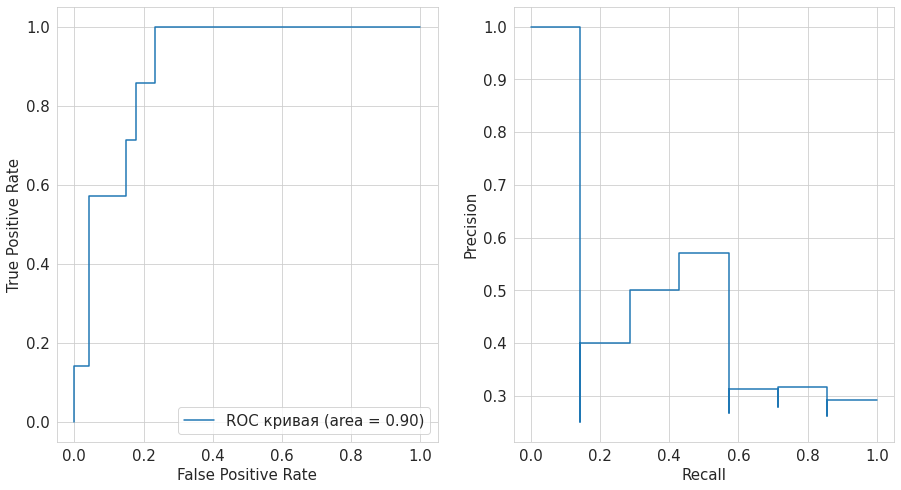

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=log_model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=log_model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

roc_display.plot(ax=ax1, label='ROC кривая (area = %0.2f)' %auc)
pr_display.plot(ax=ax2)
plt.show()

> Модель c Type 1 и без использования этой переменной почти одинаковые. Будем использоваьт модель без Type 1.

In [88]:
# Для без Type 1
coefficients = np.hstack((log_model.intercept_, log_model.coef_[0]))
coefficients_df = pd.DataFrame(data={'variable': ['intercept'] + list(X.drop('Type 1', axis=1).columns), 'coefficient': coefficients})
coefficients_df

,variable,coefficient
0,intercept,-6.918015
1,Total,1.146248
2,HP,0.643192
3,Attack,0.151973
4,Defense,0.697928
5,Sp. Atk,0.901318
6,Sp. Def,1.174768
7,Speed,1.185689
8,Generation,0.770910


In [89]:
import math

for_print = coefficients_df['coefficient'][0]
print(f'При прочих равных условиях, шанс быть легендарным у покемона {round(math.exp(for_print), 5)}.')

При прочих равных условиях, шанс быть легендарным у покемона 0.00099.


#### Определение признаков, важных для модели

In [90]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = X.drop('Type 1', axis=1).columns

X_test_df = pd.DataFrame(X_test)
X_test_df.columns = X.drop('Type 1', axis=1).columns

In [91]:
print('Size of X_train_df: ', X_train_df.shape)
print('Size of y_train: ', y_train.shape)

print('Size of X_test_df: ', X_test_df.shape)
print('Size of y_test: ', y_test.shape)

Size of X_train_df:  (720, 8)
Size of y_train:  (720,)
Size of X_test_df:  (80, 8)
Size of y_test:  (80,)


In [92]:
X_test_df.columns

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation'],
      dtype='object')

##### Total

In [93]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Total', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Total', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Total', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 92.5
AUC (площадь под ROC кривой): 0.91


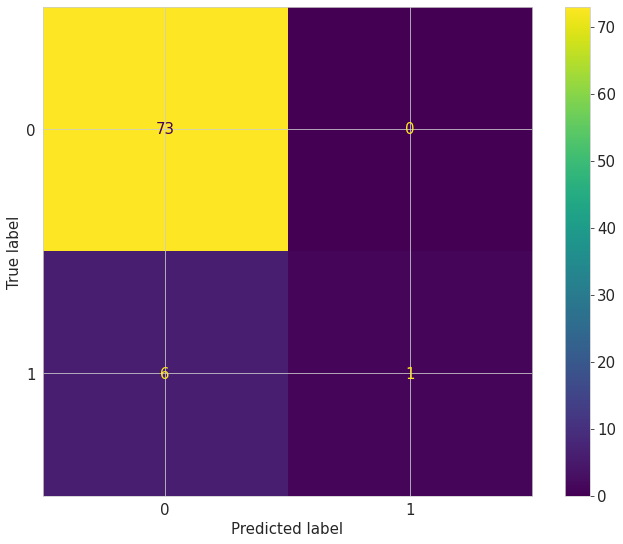

In [94]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### HP

In [95]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('HP', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('HP', axis=1))
y_score = log_model.decision_function(X_test_df.drop('HP', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 90.0
AUC (площадь под ROC кривой): 0.90


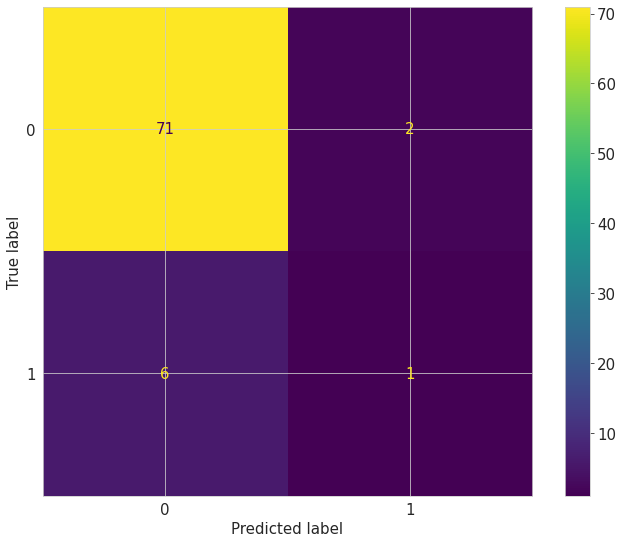

In [96]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Attack

In [97]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Attack', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Attack', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Attack', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 90.0
AUC (площадь под ROC кривой): 0.90


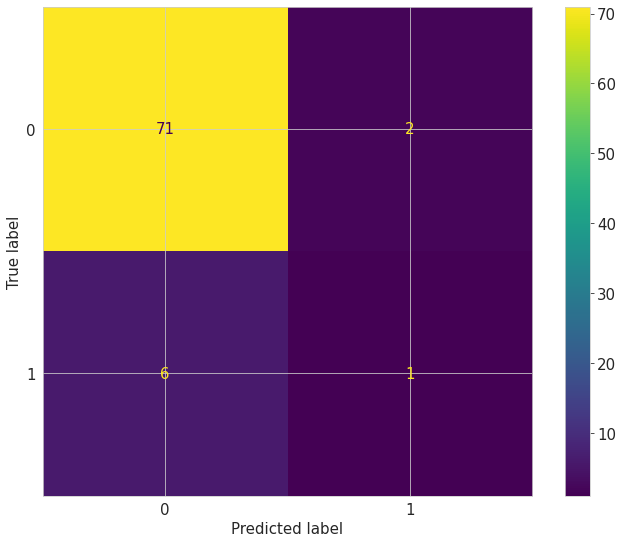

In [98]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Defense

In [99]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Defense', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Defense', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Defense', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 88.75
AUC (площадь под ROC кривой): 0.91


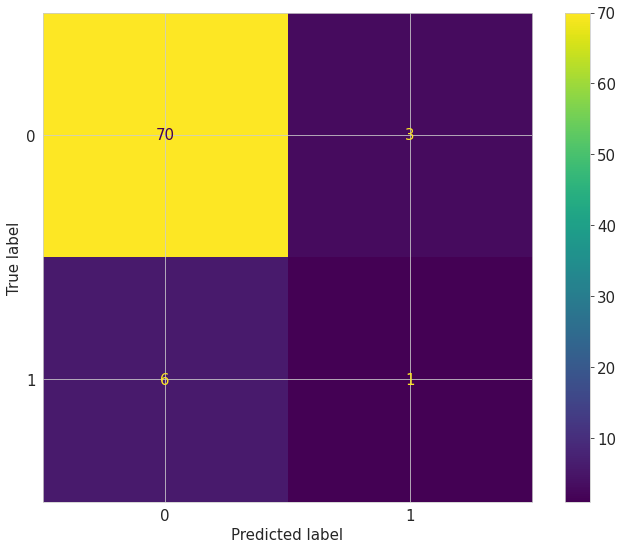

In [100]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Sp. Atk

In [101]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Sp. Atk', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Sp. Atk', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Sp. Atk', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 90.0
AUC (площадь под ROC кривой): 0.89


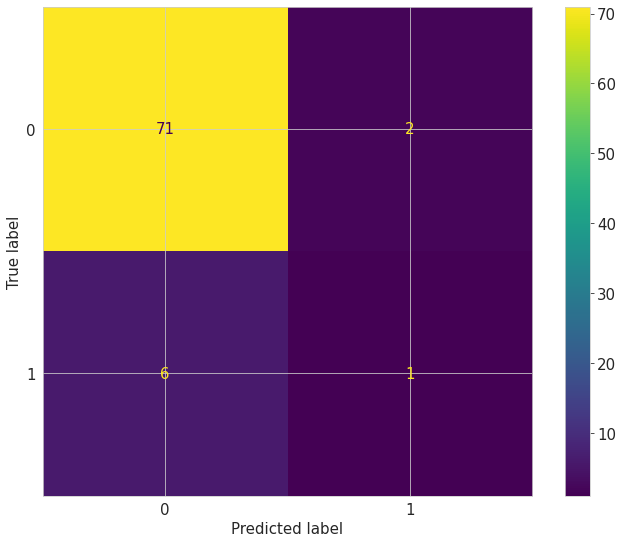

In [102]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Sp. Def

In [103]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Sp. Def', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Sp. Def', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Sp. Def', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 92.5
AUC (площадь под ROC кривой): 0.92


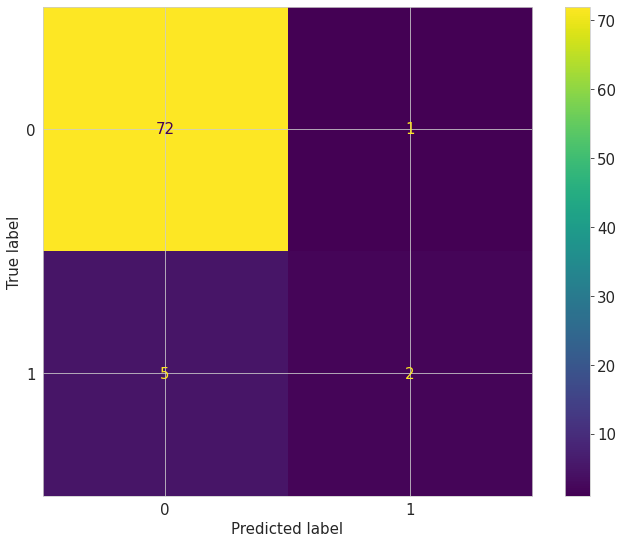

In [104]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Speed

In [105]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Speed', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Speed', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Speed', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 88.75
AUC (площадь под ROC кривой): 0.90


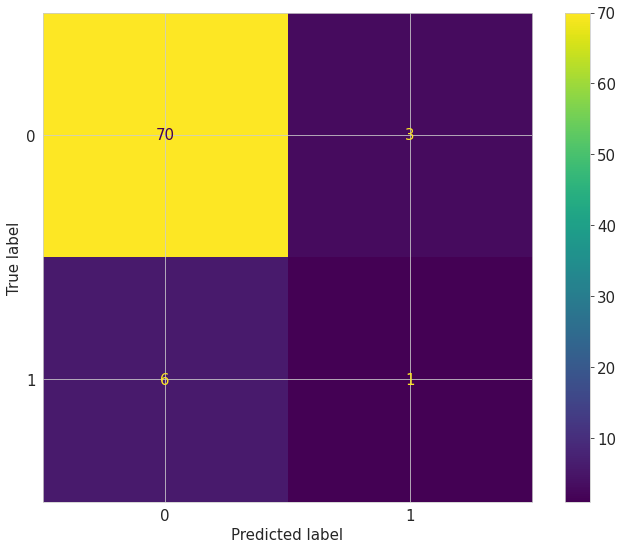

In [106]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

##### Generation

In [107]:
log_model = LogisticRegression()

log_model.fit(X_train_df.drop('Generation', axis=1), y_train)

y_pred = log_model.predict(X_test_df.drop('Generation', axis=1))
y_score = log_model.decision_function(X_test_df.drop('Generation', axis=1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 92.5
AUC (площадь под ROC кривой): 0.91


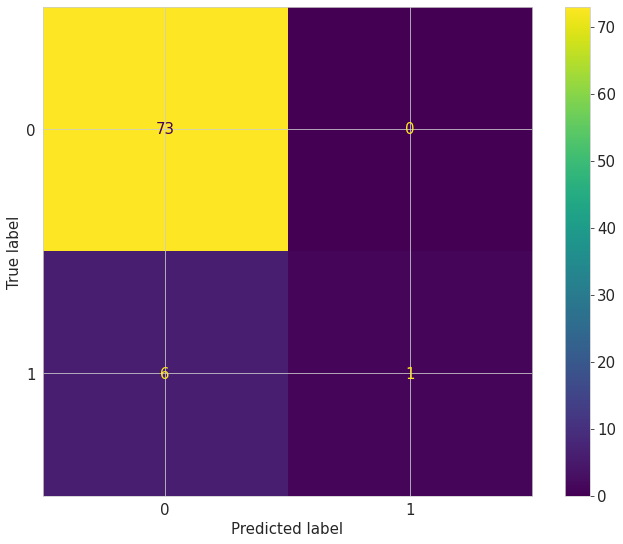

In [108]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

Если предсказывать легендарность только по Generation?

In [109]:
log_model = LogisticRegression()

log_model.fit(X_train_df['Generation'].values.reshape(-1, 1), y_train)

y_pred = log_model.predict(X_test_df['Generation'].values.reshape(-1, 1))
y_score = log_model.decision_function(X_test_df['Generation'].values.reshape(-1, 1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 91.25
AUC (площадь под ROC кривой): 0.47


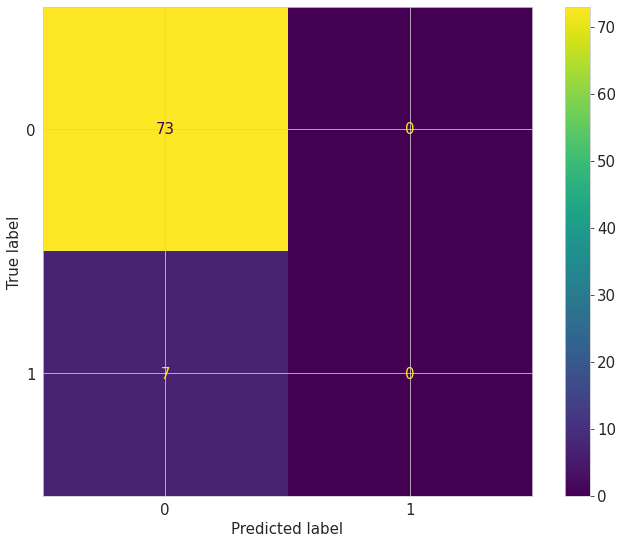

In [110]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

Не-легендарность при использовании только Generation предсказывается хорошо, легендарность не предсказывается. 


Построим модель используя Speed и Total и Sp. Def, имеющие максимальные коэффициенты в модели со всеми количественными признаками.

In [117]:
log_model = LogisticRegression()

log_model.fit(X_train_df[['Speed', 'Total', 'Sp. Def']], y_train)

y_pred = log_model.predict(X_test_df[['Speed', 'Total', 'Sp. Def']])
y_score = log_model.decision_function(X_test_df[['Speed', 'Total', 'Sp. Def']])

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 91.25
AUC (площадь под ROC кривой): 0.92


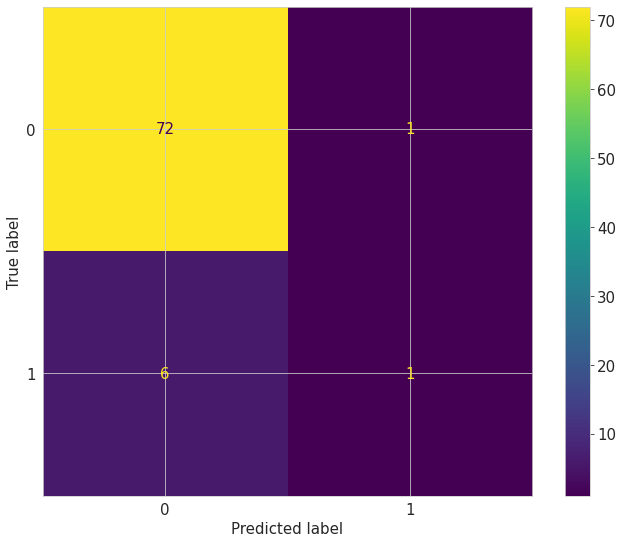

In [118]:
plt.rcParams['font.size'] = 15.0
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
plt.close()

In [113]:
log_model = LogisticRegression()

log_model.fit(X_train_df['Speed'].values.reshape(-1, 1), y_train)

y_pred = log_model.predict(X_test_df['Speed'].values.reshape(-1, 1))
y_score = log_model.decision_function(X_test_df['Speed'].values.reshape(-1, 1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 91.25
AUC (площадь под ROC кривой): 0.87


In [114]:
log_model = LogisticRegression()

log_model.fit(X_train_df['Total'].values.reshape(-1, 1), y_train)

y_pred = log_model.predict(X_test_df['Total'].values.reshape(-1, 1))
y_score = log_model.decision_function(X_test_df['Total'].values.reshape(-1, 1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 93.75
AUC (площадь под ROC кривой): 0.94


In [116]:

log_model = LogisticRegression()

log_model.fit(X_train_df['Sp. Def'].values.reshape(-1, 1), y_train)

y_pred = log_model.predict(X_test_df['Sp. Def'].values.reshape(-1, 1))
y_score = log_model.decision_function(X_test_df['Sp. Def'].values.reshape(-1, 1))

print("Accuracy = {}".format(accuracy_score(y_test, y_pred)*100))
print('AUC (площадь под ROC кривой): %.2f' % roc_auc_score(y_test, y_score))

Accuracy = 90.0
AUC (площадь под ROC кривой): 0.62


> Важными для модели являются 'Speed', 'Total', но можно получить хорошую модель используя только Total, и чуть хуже с использованием только Speed.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

На данный момент любимые - eskimo callboy. Вынесли рекомендации в музыке вк очень давно.\
[тык1](https://youtu.be/x27O7v5lx5Q)\
[тык2](https://youtu.be/Mj0e1DvUFk8)\
[тык3](https://youtu.be/D1NdGBldg3w)\
[тык4](https://youtu.be/x44bG7yX0Q8?t=70)


## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Интересно. Всё еще не очень понятно как сравнивать модели и выбирать лучшие признаки.
